# Floodwater Depth Estimation Tool (FwDET) version 2.1
Program procedure:
 1. Flood extent polygon to polyline
 2. Polyline to Raster - DEM extent and resolution (Env)
 3. Con - DEM values to Raster
 4. Euclidean Allocation - assign boundary cell elevation to nearest domain cells
 5. Calculate water depth by deducting DEM by Euclidean Allocation
 6. Run low-pass Filter
 
Created by Sagy Cohen, Surface Dynamics Modeling Lab, University of Alabama
email: sagy.cohen@ua.edu; web: http://sdml.ua.edu

## Set input and output variables 

In [5]:
arcpy.env.overwriteOutput = True
infolder = r'C:\Workspace\Boise\\'
ws = arcpy.env.workspace = infolder+ 'Geodatabase.gdb'

dem_name = infolder+'NEDelevation.tif'
inund_polygon = infolder+'WaterExtent.shp'
clip_dem = 'ClipDEM'
cost_raster = infolder+'CostRaster1.tif'
WaterDepthOutput = 'WaterDepth_i10_s0p5'
iterations = 10
SlopeFiltering = True
SlopeThreshold = 0.5
#WaterDepthOutput = 'WaterDepth_i{0}_s{1}'.format(iterations,SlopeThreshold)

## Housekeeping

In [6]:
dem = arcpy.Raster(dem_name)
cell_size = dem.meanCellHeight
# Proper string representation of dem extent to be accepted by Clip_management method
extent = '{} {} {} {}'.format(dem.extent.XMin, dem.extent.YMin, dem.extent.XMax, dem.extent.YMax)

if not arcpy.Exists(cost_raster):
    cost_raster = (((dem <= 0)*999)+1)
    cost_raster.save('CostRaster')

if not clip_dem:
    clip_dem = 'ClipDEM'
    arcpy.management.Clip(dem, extent, clip_dem, inund_polygon, nodata_value= "-9999", clipping_geometry="ClippingGeometry", maintain_clipping_extent="NO_MAINTAIN_EXTENT")
clip_dem_ras = arcpy.Raster(clip_dem)

## Calculate boundary raster 

In [7]:
arcpy.env.overwriteOutput = True
polyline = 'polyline'
arcpy.PolygonToLine_management(inund_polygon, polyline)
# Convert polyline to raster
with arcpy.EnvManager(snapRaster=clip_dem_ras):
    arcpy.conversion.PolylineToRaster(polyline, 'OBJECTID', 'linerast15', "MAXIMUM_LENGTH", "NONE", cell_size)
raster_polyline = arcpy.Raster('linerast15')
raster_polyline.save("raster_polylin")
# The input whose values will be used as the output cell values if the condition is false.
inFalseConstant = '#'
where_clause = 'VALUE >= 0'
#Extract the boundary cells elevation from DEM
boundary = arcpy.sa.Con(raster_polyline, dem, inFalseConstant, where_clause)
# boundary.save('boundary1')
#Smooth boundary raster
for i in range(iterations):
    print('Focal iteration '+str(i+1))
    OutRasTemp = arcpy.sa.FocalStatistics(boundary, "Rectangle 5 5 CELL", 'MEAN', 'DATA')
    boundary = arcpy.sa.Con(raster_polyline, OutRasTemp, inFalseConstant, where_clause)
    boundary.save('boundary'+str(i+1))
#Identify and remove ocean boundary cells
OutRasTemp = arcpy.sa.FocalStatistics(dem, 'Circle 2 CELL', 'MINIMUM', 'DATA') 
whereClause2 = 'VALUE > 0'
boundary = arcpy.sa.Con(OutRasTemp, boundary, inFalseConstant, whereClause2)
#boundary.save("boundaryAfterOcean")
if SlopeFiltering:
#calculate topo slope
    print('Calculating Slope')
    extent_clip = '{} {} {} {}'.format(boundary.extent.XMin, boundary.extent.YMin, boundary.extent.XMax, boundary.extent.YMax)
    with arcpy.EnvManager(extent=extent_clip):
        out_slope = arcpy.sa.Slope(dem, "PERCENT_RISE", 1, "GEODESIC", "METER")
        out_slope.save("Slope_m")
#Remove erroneous boundary cells 
    whereClause_slope = 'VALUE > ' + str(SlopeThreshold)
    boundary = arcpy.sa.Con(out_slope, boundary, inFalseConstant, whereClause_slope)
boundary.save("boundFinal")
print('Finished calculating the boundary raster')

Focal iteration 1
Focal iteration 2
Focal iteration 3
Focal iteration 4
Focal iteration 5
Focal iteration 6
Focal iteration 7
Focal iteration 8
Focal iteration 9
Focal iteration 10
Calculating Slope
Finished calculating the boundary raster


## Calculate the water depth raster

Running cost allocation
Cost Allocation raster generated
Calculating estimated water depth
Floodwater depth computed


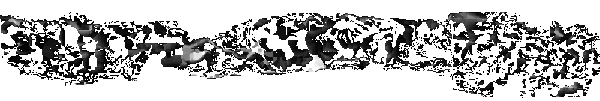

In [8]:
MULTIPLIER = 10000
boundary_int = arcpy.sa.Int(boundary * MULTIPLIER)
#boundary_int.save("boundary_int")
print('Running cost allocation')
with arcpy.EnvManager(snapRaster=None, extent="DEFAULT", mask=clip_dem):
    cost_alloc = arcpy.sa.CostAllocation(boundary_int, cost_raster, '#', '#', 'Value')

# Divide the result from the cost allocation function using the same constant used to create the integer
# representation of the boundary
cost_alloc = arcpy.sa.Float(cost_alloc) / MULTIPLIER
print('Cost Allocation raster generated')
print('Calculating estimated water depth')
water_depth = (cost_alloc - clip_dem_ras)
# Remove estimated water depths below 0 and change them to 0
water_depth = arcpy.sa.Con(water_depth > 0, water_depth,"#")
water_depth.save(WaterDepthOutput)
print('Floodwater depth computed')
water_depth

## Calculate smooth water depth raster (low-pass filter)

Running low-pass Filter
Finished low-pass Filter calculation


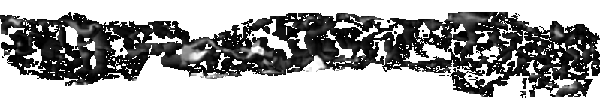

In [9]:
#Run a low-pass filter
print('Running low-pass Filter')
water_depth_filtered = arcpy.sa.Filter(water_depth, 'LOW', 'DATA')
waterDepthFilter2 = arcpy.sa.Con(clip_dem_ras, water_depth_filtered, '#', 'VALUE > 0')
waterDepthFilter2.save(WaterDepthOutput+'_filtered')
print('Finished low-pass Filter calculation')
waterDepthFilter2